# Setup

In [2]:
# import Includes
from Methods import *

# matplotlib.rcParams['figure.dpi'] = 100

In [3]:
def sinusoid(frequency, T, p = 0, SR = 48000, dtype = 'float'):
    phase = 2 * np.pi * (frequency * np.arange(0, T, 1 / SR) - p)
    if dtype == 'complex':
        return np.exp(1j * phase)
    return np.sin(phase)

def square(frequency, T, p = 0, SR = 48000):
    return sum(sinusoid(frequency * n, T, p, SR) / n for n in range(1, SR // (2 * frequency), 2))

def saw(frequency, T, p = 0.5, SR = 48000):
    return sum(sinusoid(frequency * n, T, p, SR) / n for n in range(1, SR // (2 * frequency)))


# Visualization

In [4]:
SR = 48000
T = 3
d = np.array([0, SR // 60])
T = 0.5
fm = 60

# fs = [110, 115, 120, 125, 130]
fs = [100, 110, 120, 130, 140]
sinusoids = [sinusoid(f, T) for f in fs]
squares = [square(f, T) for f in fs]
saws = [saw(f, T) for f in fs]

harms = 7
sinstacks = [sum(sinusoid(n * f, T) / n ** 2 for n in range(1, harms+1)) for f in fs]
squarestacks = [sum(square(n * f, T) / n ** 2 for n in range(1, harms+1)) for f in fs]
sawstacks = [sum(saw(n * f, T) / n ** 2 for n in range(1, harms+1)) for f in fs]

collections = [sinusoids, squares, saws, sinstacks, squarestacks, sawstacks]

for collection in collections:
    for i in range(len(fs)):
        collection[i] /= np.max(np.abs(collection[i]))

In [15]:
def timbre_vs_frequency(collections, d, name):
    color = plt.cm.rainbow(np.linspace(0, 1, len(d)))
    fig, ax = plt.subplots(nrows = len(collections[0]), ncols = len(collections))
    for i, collection in enumerate(tqdm(collections)):
        for j, s in enumerate(collection):
            a = ax[j,i]
            a.set_xlim([-np.sqrt(len(d)),np.sqrt(len(d))])
            a.set_ylim([-np.sqrt(len(d)),np.sqrt(len(d))])
            a.set_aspect('equal')
            a.set_axis_off()

            trajectory, bases, distances = analyze(s, d, 2, randomize = False, seed = False)

            K = SR // fm
            segments = np.zeros((K - 1, 2, 2))
            segments[:,0] = trajectory[-K:-1]
            segments[:,1] = trajectory[-K+1:]

            distances = distances[-K:]
            darknesses = 0.5 * (1 - distances)
            colors = np.zeros((K - 1, 4))
            for l, _ in enumerate(colors):
                colors[l] = (darknesses[l], darknesses[l], darknesses[l], 1)

            lc = LineCollection(segments, color = colors, linewidth = 1, path_effects=[path_effects.Stroke(capstyle="round")])
            a.add_collection(lc)

            # a.plot(*trajectory[-K:].T, linewidth = 1)
            if (len(d) > 2):
                for n, c in zip(range(len(d)), color):
                    a.plot(*(0.75 * np.sqrt(len(d)) * bases[-K:, n].T), c = c, linewidth = 2, alpha = 0.75, solid_capstyle='round')
                
    plt.savefig(f'Fig/{name}.pdf', bbox_inches='tight')  

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:07<00:00, 11.19s/it]


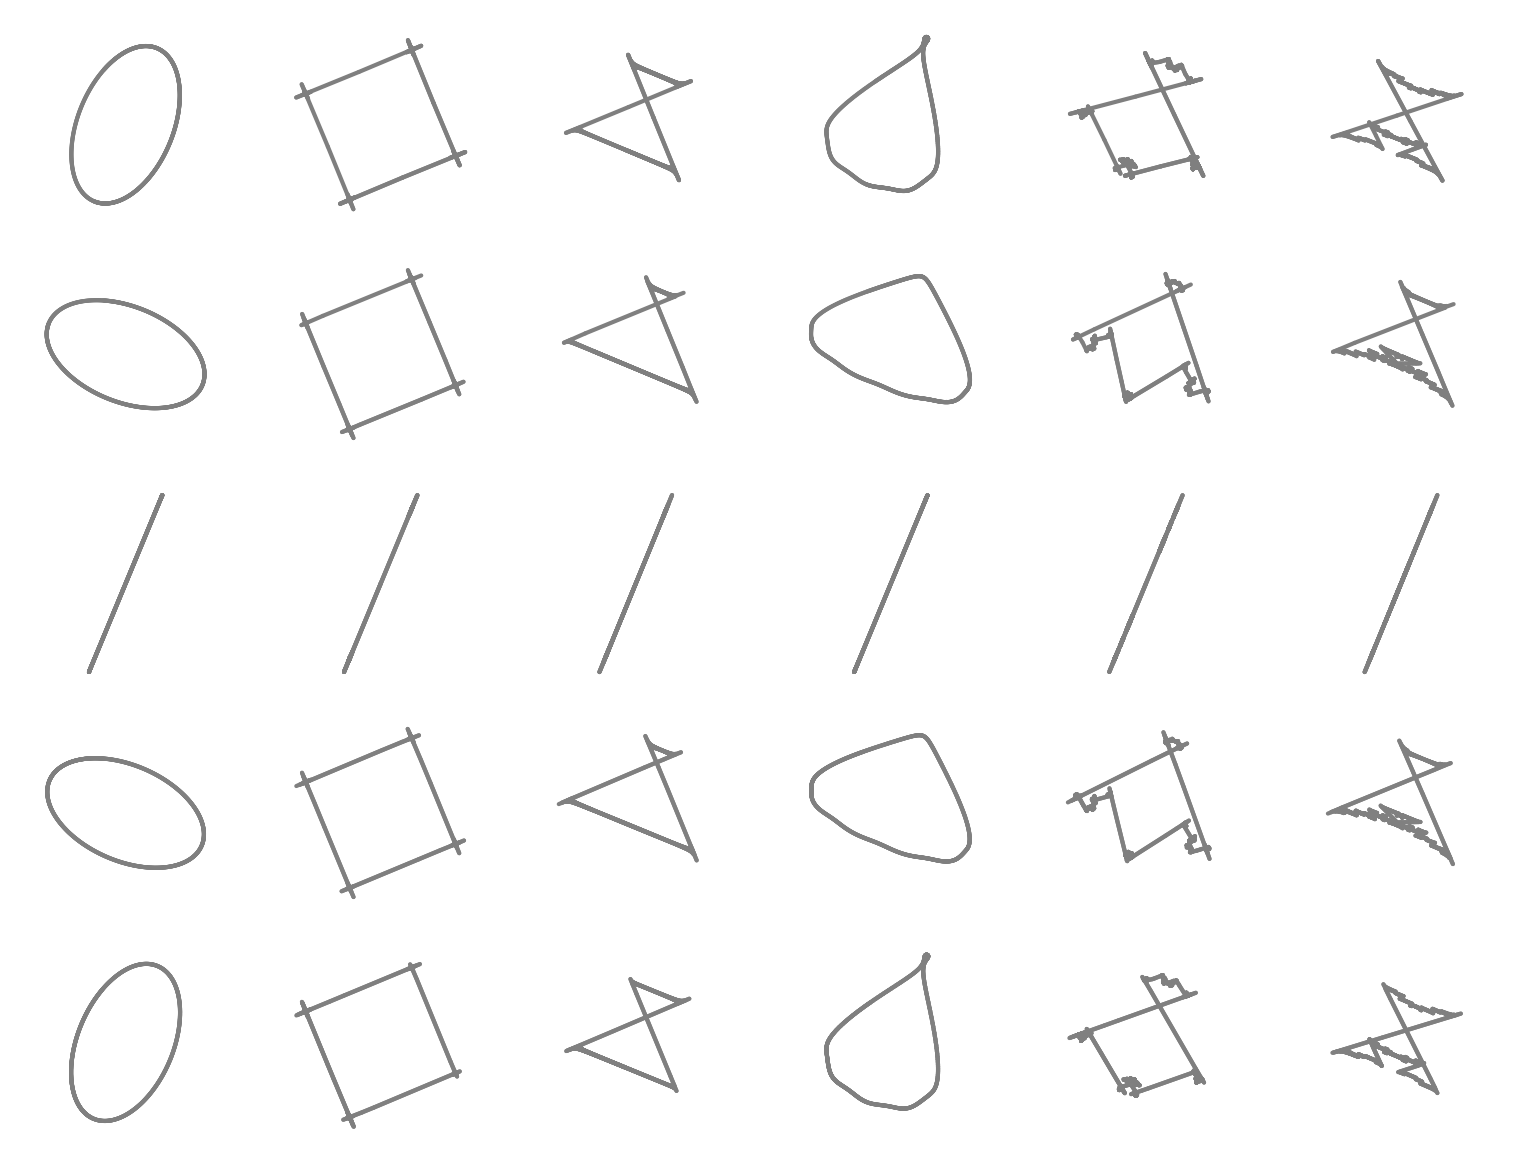

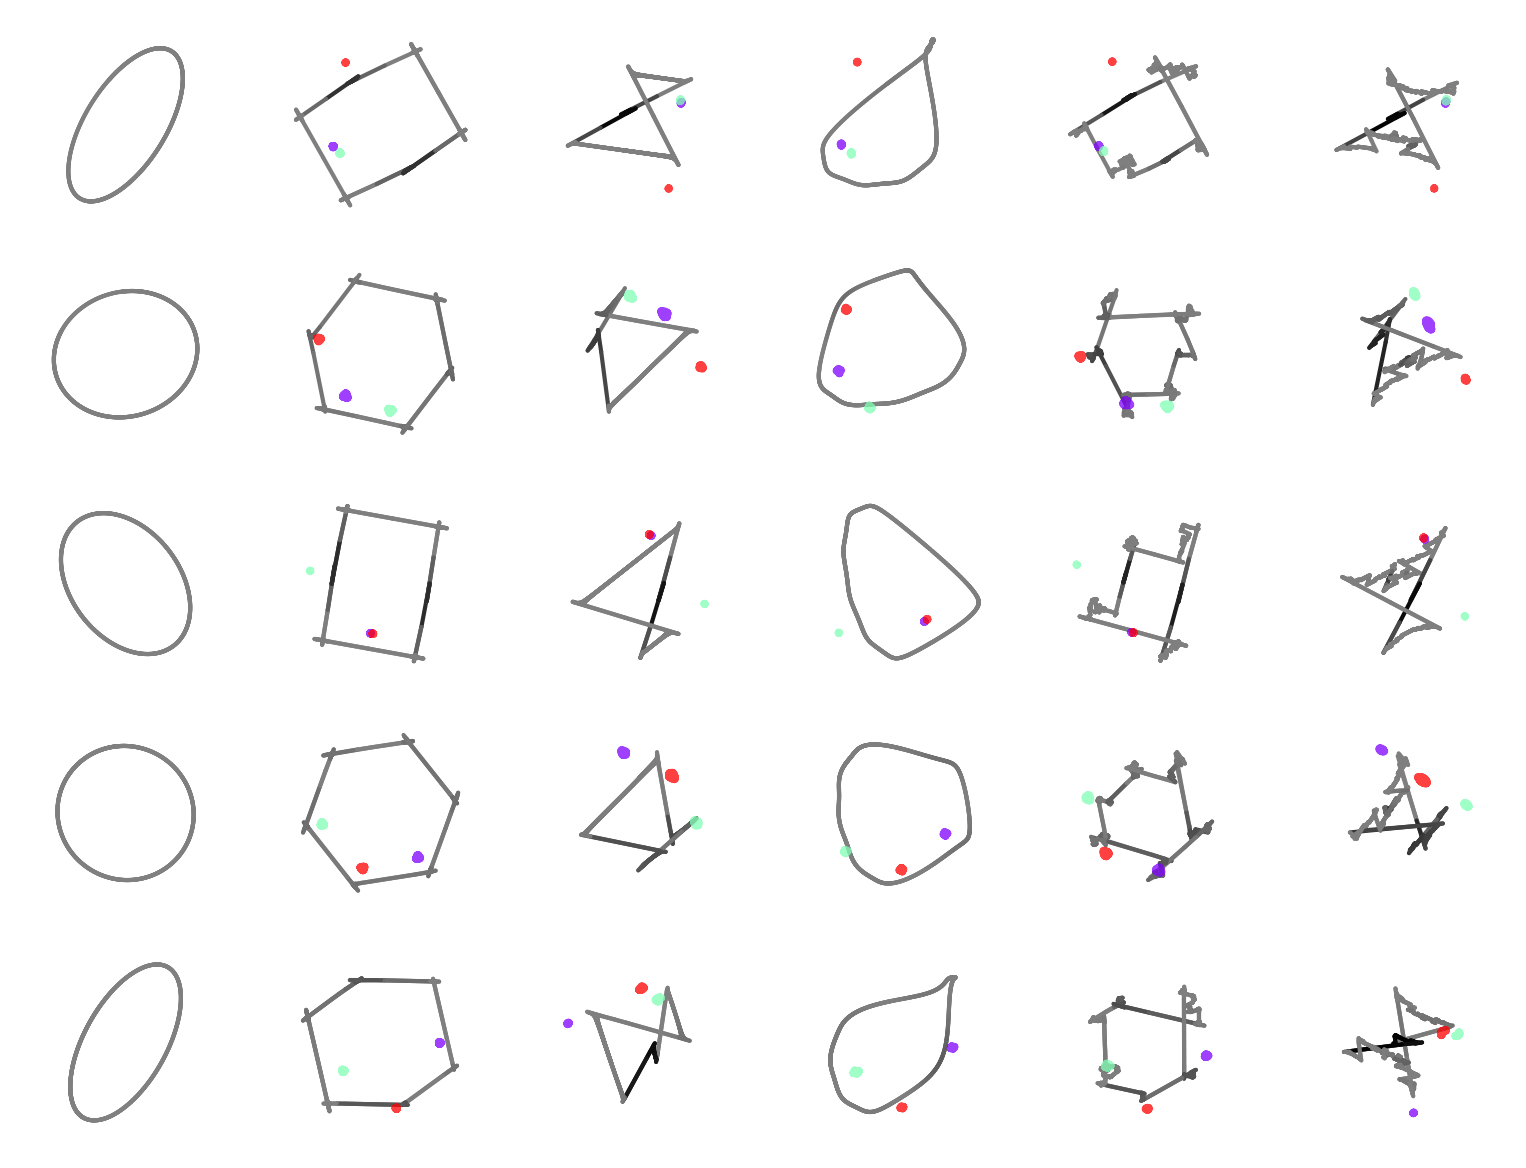

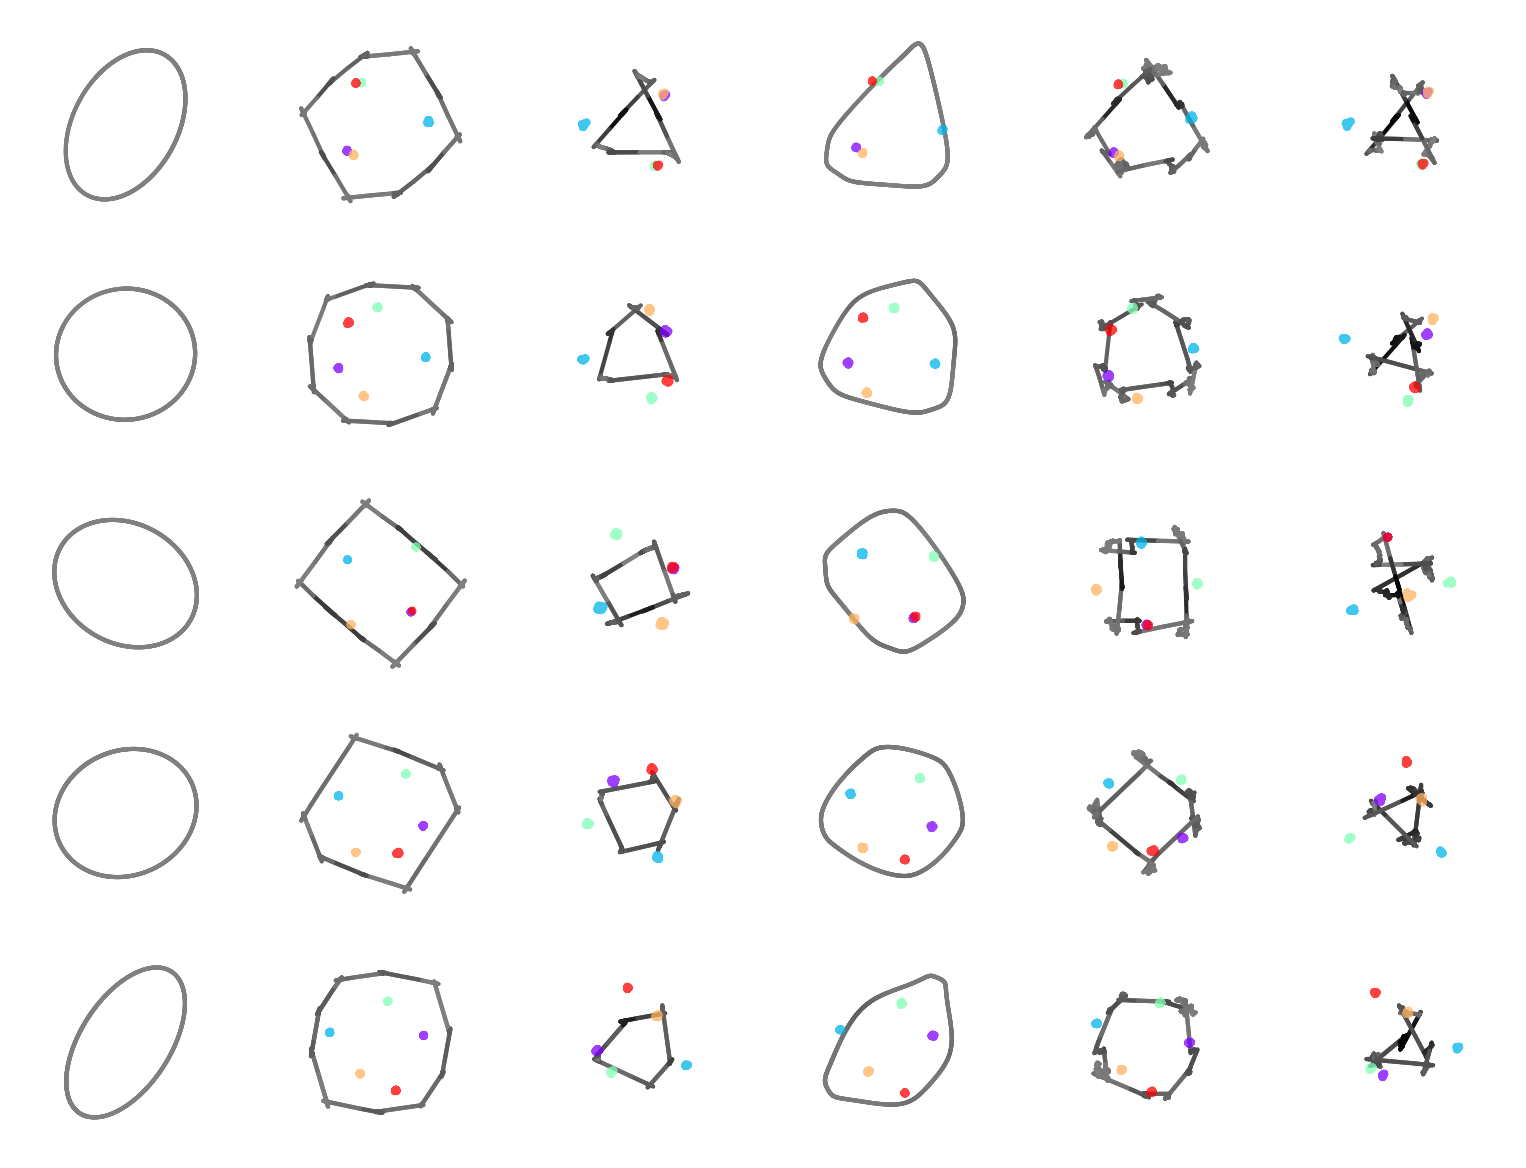

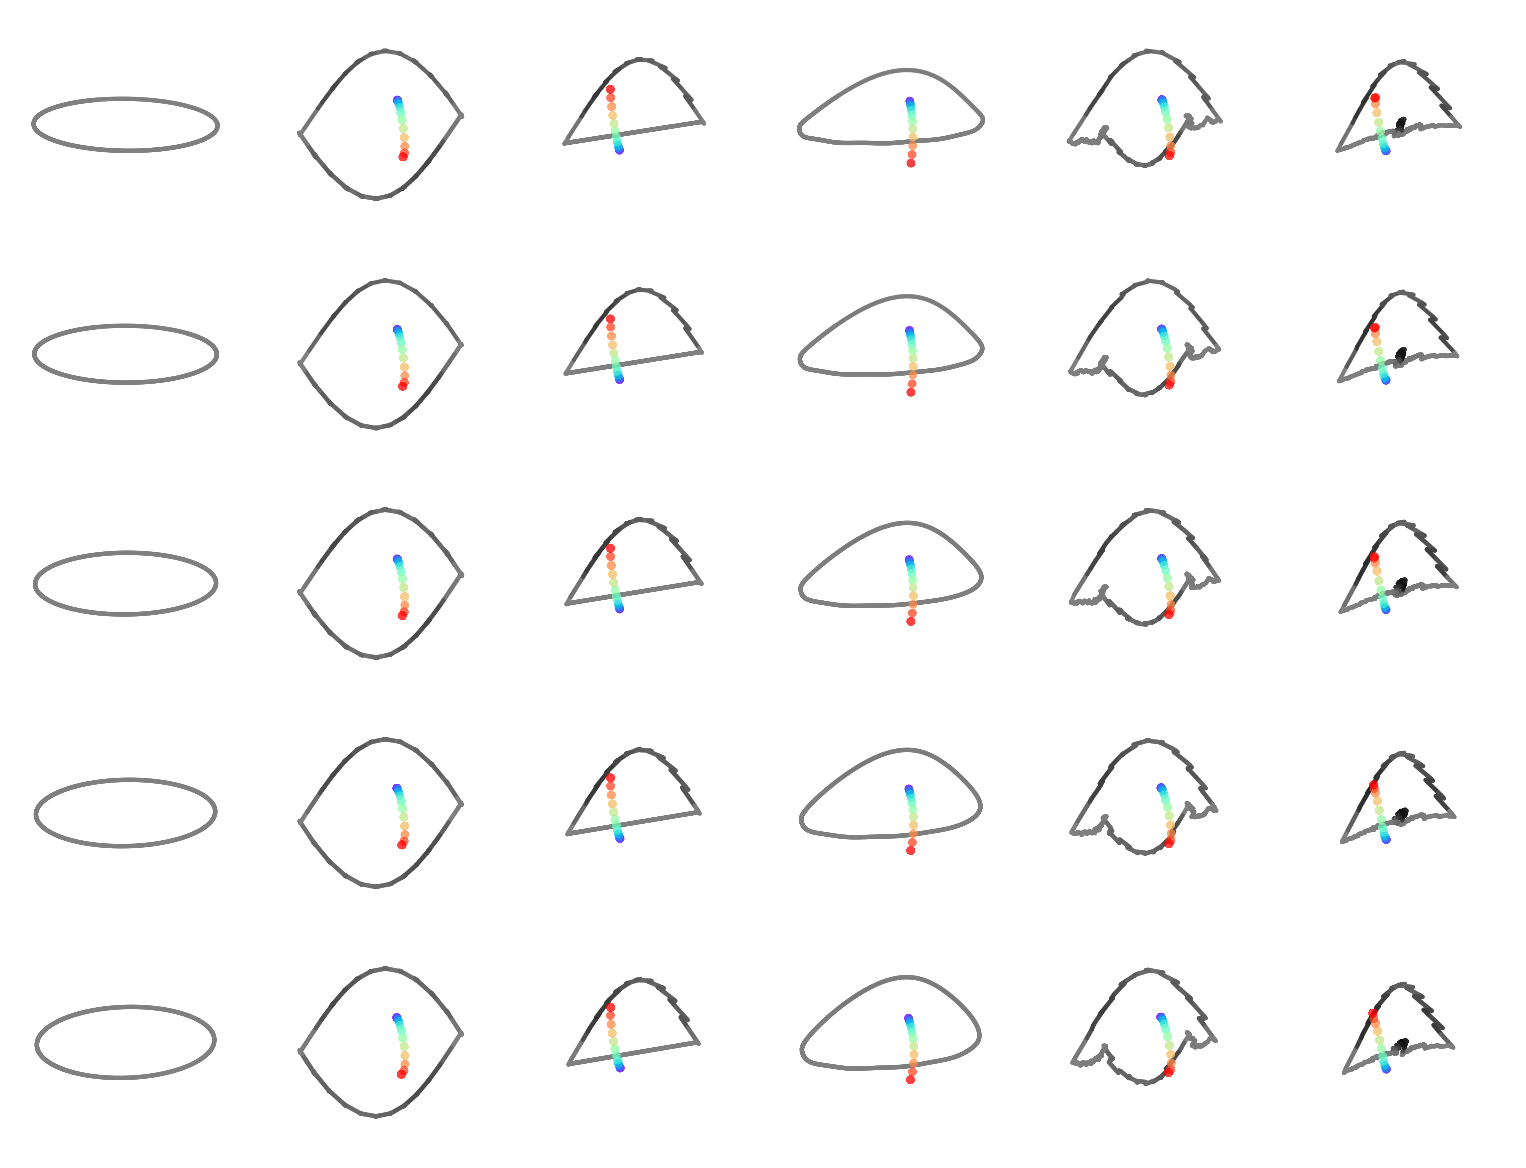

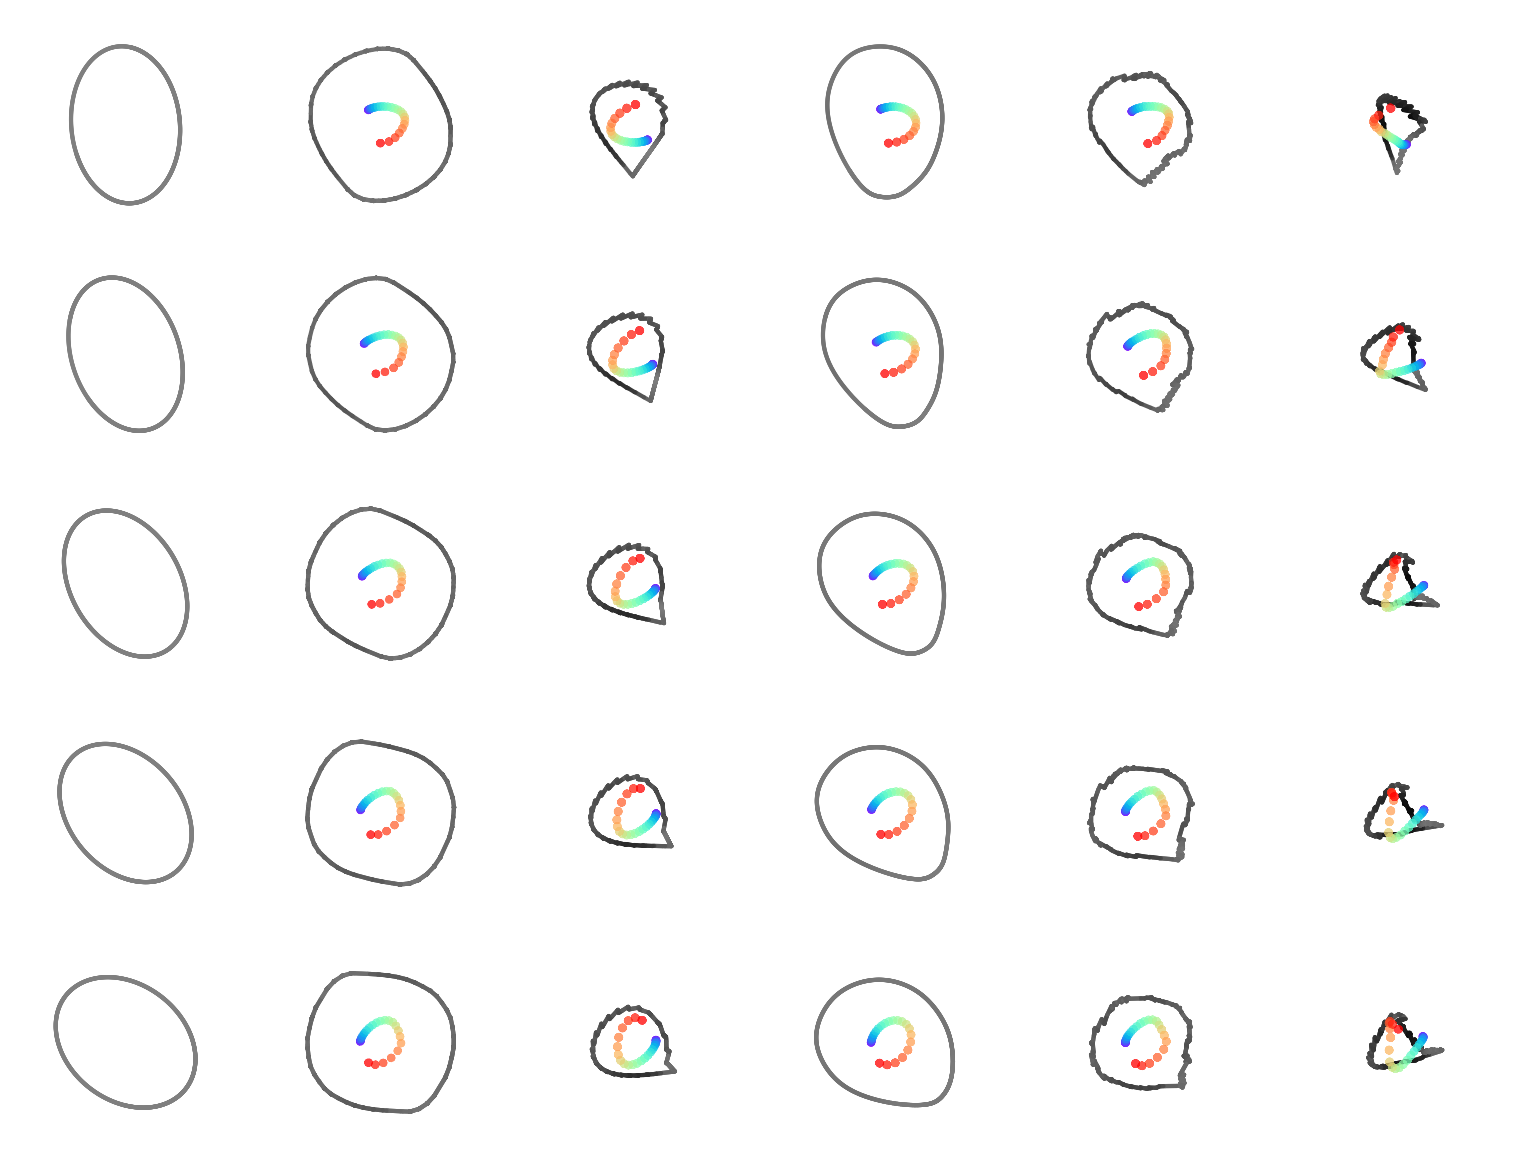

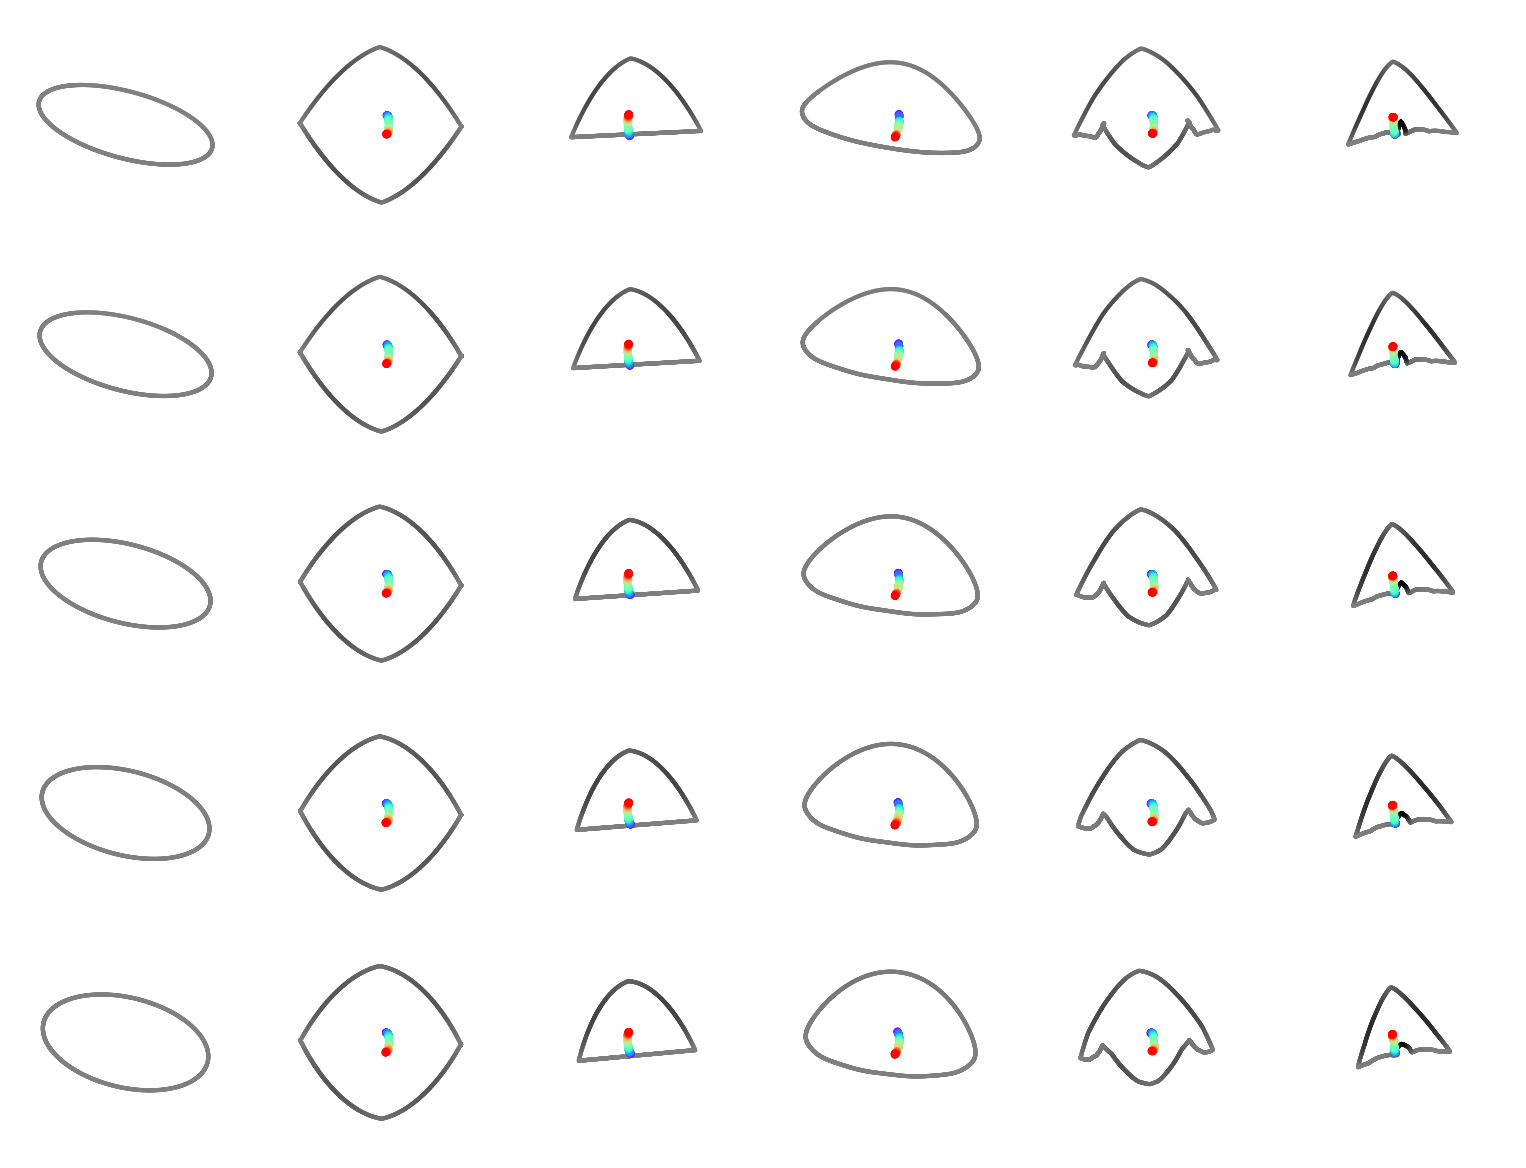

In [7]:
timbre_vs_frequency(collections, [0,800], '1.basic')
timbre_vs_frequency(collections, [0,491,797], '2.3d')
timbre_vs_frequency(collections, [0,191,307,491,797], '3.5d')
timbre_vs_frequency(collections, np.cumsum(range(12)), '4.12d')
timbre_vs_frequency(collections, np.cumsum(range(24)), '5.24d')
timbre_vs_frequency(collections, tuple(range(96)), '6.highd')

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [06:02<00:00, 60.47s/it]


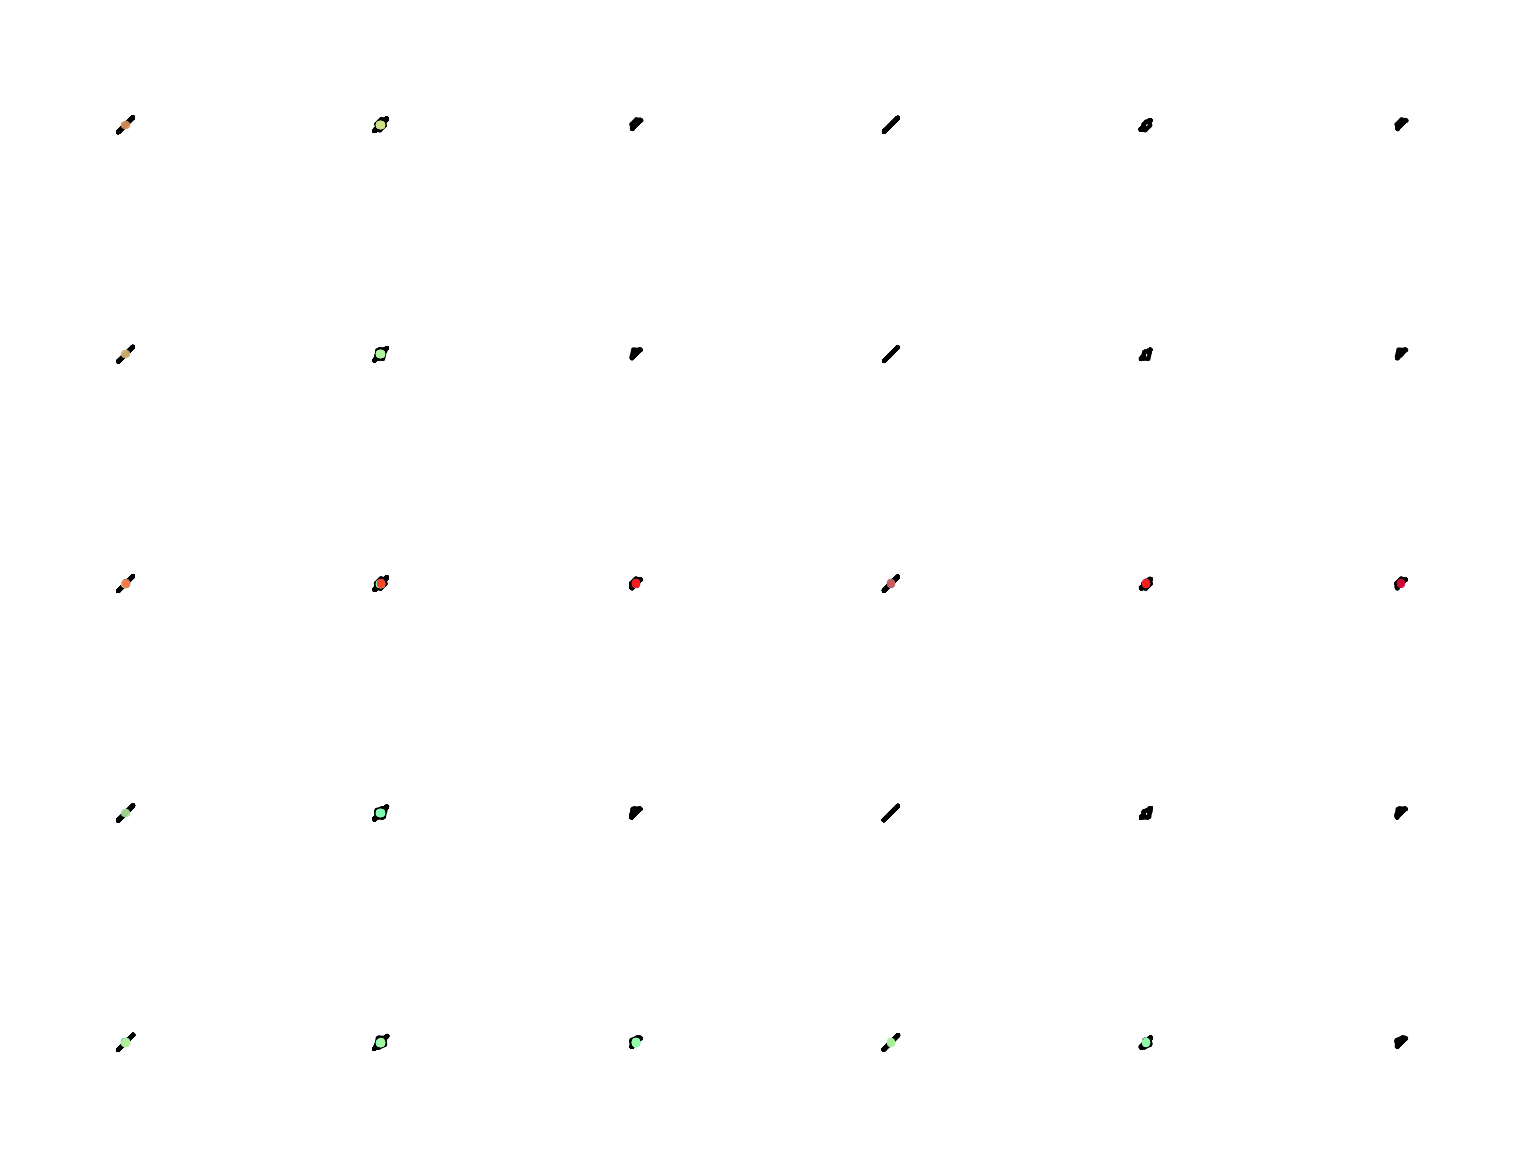

In [16]:
timbre_vs_frequency(collections, tuple(range(384)), '9.highd')

In [1]:
# modify to point to your installation of OrchideaSOL
# (the directory given should be the one containing folders "Winds", "Strings", "PluckedStrings", etc.)

SOLPath = "/Users/amc/Downloads/OrchideaSOL2020/"

In [2]:
import os

# Initialize an empty dictionary to store the file paths
file_dict = {}

# Traverse the directory structure
for root, dirs, files in os.walk(SOLPath):
    for file in files:
        # Ignore .DS_Store files
        if file == ".DS_Store":
            continue
        
        # Split the filename to extract parameters
        parts = file.split('-')
        
        # Extract parameters
        instrument = parts[0]
        playing_style = parts[1]
        note = parts[2]
        dynamic = parts[3]
        
        # Create dictionary keys if they don't exist
        if instrument not in file_dict:
            file_dict[instrument] = {}
        if playing_style not in file_dict[instrument]:
            file_dict[instrument][playing_style] = {}
        if note not in file_dict[instrument][playing_style]:
            file_dict[instrument][playing_style][note] = {}
        if dynamic not in file_dict[instrument][playing_style][note]:
            file_dict[instrument][playing_style][note][dynamic] = []
        
        # Append file path to the dictionary
        file_dict[instrument][playing_style][note][dynamic].append(os.path.join(root, file))

In [3]:
file_dict['Fl']['ord']['A4']

{'pp': ['/Users/amc/Downloads/OrchideaSOL2020/Winds/Flute/ordinario/Fl-ord-A4-pp-N-T18u.wav'],
 'ff': ['/Users/amc/Downloads/OrchideaSOL2020/Winds/Flute/ordinario/Fl-ord-A4-ff-N-N.wav'],
 'mf': ['/Users/amc/Downloads/OrchideaSOL2020/Winds/Flute/ordinario/Fl-ord-A4-mf-N-N.wav']}

In [54]:
# print("Instruments:", *file_dict)

selected = {'Fl' : 'Flute', 'ClBb' : 'Clarinet', 'Ob' : 'Oboe', 'Bn' : 'Bassoon', 'Tbn' : 'Trombone', 'Vc' : 'Cello', 'Gtr' : 'Guitar', 'Acc' : 'Accordion', 'Hp' : 'Harp'}
print("\nInstruments:", *[selected[a] for a in selected])

print("\nOrdinario A4:", *[(selected[a], [*file_dict[a]['ord']]) for a in selected], sep = '\n')

# print("\nOrdinario A3:", *[(selected[a], [*file_dict[a]['ord']['A4']]) for a in selected], sep = '\n')
# [(selected[a], [*file_dict[a]['ord']['A3']]) for a in selected]


Instruments: Flute Clarinet Oboe Bassoon Trombone Cello Guitar Accordion Harp

Ordinario A4:
('Flute', ['C6', 'G#5', 'E4', 'G4', 'F#5', 'A6', 'D#5', 'A4', 'C#6', 'G#6', 'F5', 'D5', 'C5', 'F6', 'A#4', 'B6', 'F#6', 'C#7', 'A#6', 'C#5', 'D#6', 'D6', 'B4', 'G6', 'B3', 'D#4', 'C4', 'C#4', 'D7', 'G#4', 'C7', 'F4', 'F#4', 'D4', 'G5', 'B5', 'E6', 'A5', 'A#5', 'E5'])
('Clarinet', ['F3', 'E4', 'F#4', 'C6', 'F5', 'F4', 'G4', 'D3', 'D5', 'A4', 'A5', 'G#4', 'D6', 'B4', 'A3', 'F#6', 'D4', 'G3', 'F6', 'C5', 'D#4', 'A#4', 'E6', 'C#4', 'G#5', 'D#5', 'A#3', 'B5', 'D#3', 'C#5', 'C4', 'G#3', 'G6', 'B3', 'D#6', 'C#6', 'G5', 'A#5', 'F#5', 'E3', 'E5', 'F#3'])
('Oboe', ['E4', 'C6', 'A6', 'D5', 'G4', 'G6', 'F5', 'E5', 'F#4', 'A#4', 'D#4', 'C5', 'C#4', 'F6', 'A5', 'D6', 'G#6', 'G#4', 'B4', 'A#5', 'A4', 'B3', 'G#5', 'E6', 'C4', 'F#6', 'C#6', 'C#5', 'D#5', 'F#5', 'G5', 'A#3', 'D#6', 'F4', 'D4', 'B5'])
('Bassoon', ['B2', 'B4', 'A3', 'G#3', 'C#5', 'D3', 'C5', 'D#3', 'C#3', 'D#5', 'A#2', 'E2', 'A#4', 'F#2', 'B1', '

In [18]:
print(*file_dict['Fl'])
print(*file_dict['Acc'])

ord aeol_and_ord aeol flatt dsclrd_fngr sfz whst_tn key_cl harm_fngr jet_wh
ord reg_combi breath sfz key_cl


In [66]:
A = [set([*file_dict[a]['ord']]) for a in selected]

X = A[0]
for a in A:
    X = X & a

In [67]:
X

{'A#4',
 'A4',
 'B3',
 'B4',
 'C#4',
 'C4',
 'C5',
 'D#4',
 'D4',
 'E4',
 'F#4',
 'F4',
 'G#4',
 'G4'}

In [64]:
set([1,2]) & set([2,3])

{2}

* Harmonic sum of sinusoids with varying coefficients
*  
 

In [4]:
# Example usage
# Filter files by instrument, playing style, note, and dynamic
instrument_files = file_dict['Flute']
style_files = file_dict['Flute']['aeolian']
note_files = file_dict['Flute']['aeolian']['A4']
dynamic_files = file_dict['Flute']['aeolian']['A4']['pp']

# Print file paths for demonstration
print("Files for Flute - aeolian - A4 - pp:")
for file in dynamic_files:
    print(file)

KeyError: 'Flute'

In [16]:
np.cumsum(range(20))

array([  0,   1,   3,   6,  10,  15,  21,  28,  36,  45,  55,  66,  78,
        91, 105, 120, 136, 153, 171, 190])

* A harmonic sum of sinusoids with varying coefficients
* A sum of sinusoids with varying harmonicity
* White noise pushed through a resonant filter of varying Q
* A glissando

--- 

* Constant pitch and instrument, varying dynamic
* Constant pitch and dynamic, varying instrument
* Constant instrument and dynamic, varying pitch

In [23]:
f0 = 110
overtones = 64
T = 15
darkness = 0.5
brightness = 0.99

oscillators = np.array([sinusoid(i * f0, T) for i in range(1, overtones + 1)])
lfo = darkness + (brightness - darkness) * (1 + sinusoid(1 / T, p = 0.25, T = T)) / 2
amplitudes = np.array([lfo ** i / i for i in range(1, overtones + 1)])
correction = np.sum(amplitudes, axis = 0)

signal = np.sum(oscillators * amplitudes, axis = 0) / correction

In [24]:
ipd.Audio(signal, rate = 48000)

In [25]:
plt.plot(signal[T * 48000 // 2:T * 48000 // 2 + 1000])

In [34]:

def analyze(x, delays, k, oversample = 1, alpha = 0.999, epsilon = 0.0001, delta = 0.01, gamma = 0.01, normalize = False, dtype = 'float', randomize = True, mode = 'qr', corrected = True, pad = False):
    N = len(delays)
    x = x.astype(dtype)
    # ds = np.cumsum(delays)
    ds = np.array(delays)
    
    if pad:
        X = np.append(np.zeros(ds[-1], dtype = dtype), x)
    else:
        X = x
         
    A = np.eye(N,k, dtype = dtype)
    Y = np.random.random((N,N)) + (1j if dtype == 'complex' else 0) * np.random.random((N, N))
    Y = Y - np.conj(Y.T)
    if randomize:
        A = scipy.linalg.expm(Y) @ A
    
    B = np.zeros((N,N), dtype = dtype)
    
    if pad:    
        trajectory = np.zeros((len(x), k), dtype = dtype)
        bases = np.zeros((len(x), N, k), dtype = dtype)
        distances = np.zeros(len(x), dtype = float)
        sep = np.zeros(len(x), dtype = dtype)
    else:
        trajectory = np.zeros((len(x) - ds[-1], k), dtype = dtype)
        bases = np.zeros((len(x) - ds[-1], N, k), dtype = dtype)
        distances = np.zeros(len(x) - ds[-1], dtype = float)
        sep = np.zeros(len(x) - ds[-1], dtype = dtype)

    
    try:
        for i in tqdm(range(ds[-1], len(X))):
            y = X[i - ds]
            if normalize:
                B = alpha * B + (1 - alpha) * np.outer(y, np.conj(y)) / (gamma + np.conj(y) @ y)
            else:
                B = alpha * B + (1 - alpha) * np.outer(y, np.conj(y))
                
            for j in range(oversample):
                
                Z = B @ A
                if mode == 'gradient':
                    A += epsilon * np.sqrt(N * k) * (Z - A @ (np.conj(A.T) @ Z))

                    A = A / np.linalg.norm(A, axis = 0) # orthogonalization
                    corr = np.conj(A.T) @ A
                    E = A @ (np.eye(k) - np.conj(A.T) @ A)
                    A += (1 / k) / (1 / k + np.max(np.abs(E))) * E
                    
                elif mode == 'qr':
                    C, D = scipy.linalg.qr(Z, mode = 'economic')
                    new = C

                    if corrected:
                        # if new and A have similar images, this will be close to a rotation matrix
                        Y = np.conj(new.T) @ A

                        # find the closest k x k unitary matrix
                        u, d, v = scipy.linalg.svd(Y, full_matrices = False)
                        Y = u @ v
                    else:
                        Y = np.eye(k)

                    # spin new so that it is close to the old A
                    A = new @ Y

                elif mode == 'svd':
                    # correct Z to an orthonormal basis, C
                    u, d, v = scipy.linalg.svd(Z, full_matrices = False)
                    C = u @ v
                    
                    if corrected:
                        Y = np.conj(C.T) @ A
                        
                        # find the closest k x k unitary matrix
                        u, d, v = scipy.linalg.svd(Y, full_matrices = False)
                        Y = u @ v
                    else:
                        Y = np.eye(k)

                    # spin C so that it is close to the old A
                    A = C @ Y
                    
            trajectory[i - ds[-1]] = np.conj(A.T) @ y
            bases[i - ds[-1]] = A
            if normalize:
                distances[i - ds[-1]] = np.real((np.conj(y) @ y - np.conj(trajectory[i - ds[-1]]) @ trajectory[i - ds[-1]]) / (gamma + np.conj(y) @ y))
            else:
                distances[i - ds[-1]] = np.real((np.conj(y) @ y - np.conj(trajectory[i - ds[-1]]) @ trajectory[i - ds[-1]]))
                
            sep[i - ds[-1]] = (y - A @ trajectory[i - ds[-1]])[0]
    except KeyboardInterrupt:
        return trajectory[:i-ds[-1]], bases[:i-ds[-1]], distances[:i-ds[-1]], sep[:i-ds[-1]]
    
    return trajectory, bases, distances, sep


In [35]:
# delays = [0, 2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79]
# delays = list(range(48))
delays = [0,191,307,491,797]
x = signal

In [36]:
trajectory, bases, distances, sep = analyze(x, np.array(delays), 4)

 54%|████████████████████████████████████████████████████▏                                            | 387397/719203 [00:14<00:12, 27344.88it/s]


In [29]:
params = {}
params['synth'] = True
params['SR'] = 48000

In [ ]:
pad = 1.1
fps = 60

export = True
secondary = False

K = len(trajectory)
k = bases.shape[-1]
chunks = int(K / params['SR'] * fps)

color = plt.cm.rainbow(np.linspace(0, 1, len(delays)))
box = np.max(np.abs(trajectory))

if export:
    try:
        os.mkdir('Exports/temp')
    except:
        print('temp directory exists already. Removing it.')
        !rm -r Exports/temp
        os.mkdir('Exports/temp')


indices = []
for i in range(k):
    for j in range(i + 1, k):
        indices.append((i, j))

# indices = [(i, i+1) for i in range(0, k, 2)]

plots = len(indices)
phi = (1 + np.sqrt(5)) / 2
height = np.sqrt(plots / phi)
width = plots / height

cx, cy = int(np.floor(width)), int(np.floor(height))
options = [(cx, cy), (cx + 1, cy), (cx, cy + 1), (cx + 1, cy + 1)]
options = [(a * b, (a, b)) for (a, b) in options if a * b >= plots]
options.sort()

width, height = options[0][1]

ds = delays

segments = np.zeros((K - 1, 2, k))
segments[:,0] = trajectory[:-1]
segments[:,1] = trajectory[1:]

darknesses = 0.9 * (1 - (distances / (np.max(distances) + 0.2) + (1 - np.max(distances) / (np.max(distances) + 0.2))))
darknesses = np.clip(darknesses, 0, 1)
colors = np.zeros((K - 1, 4))
for i, a in enumerate(colors):
    colors[i] = (darknesses[i], darknesses[i], darknesses[i], 1)


for i in (tqdm(range(chunks)) if export else range(chunks)): 
    split = slice((K * i) // chunks, (K * (i + 1)) // chunks)
    
    fig, ax = plt.subplots(ncols = width, nrows = height)
    
    for yi in range(height):
        for xi in range(width):
            j = xi + yi * width
            if (j >= plots):
                break
            
            dims = indices[j]
            if (width * height > 1):
                a = ax[yi, xi]
            else:
                a = ax
            a.set_xlim([pad * -box, pad * box])
            a.set_ylim([pad * -box, pad * box])
            a.set_aspect('equal')
            a.set_axis_off()
            
            lc = LineCollection(segments[split,:,dims], color = 'black', alpha = 0.75, linewidth = 1, path_effects=[path_effects.Stroke(capstyle="round")])
            a.add_collection(lc)
            
            for n,c in zip(range(len(delays)), color):
                C = box * bases[split, n, dims].T
                # points = np.mean(C, axis=1)
                # spread = np.sqrt(np.mean((C - np.outer(points, np.ones(C.shape[1]))) ** 2))
                # C = np.insert(C, slice(1, None, 2), 0, axis=1)
                a.plot(*C, c = c, linewidth = 0.75, alpha = 0.5, solid_capstyle='round')
                # a.scatter(points[0], points[1], c = [c], linewidths = [spread], alpha = 0.5)
        

    imgname = 'Exports/temp/step' + str(i).zfill(int(np.log10(chunks) + 1)) + '.png'
    plt.savefig(imgname, dpi = 300)
    plt.close('all')


temp directory exists already. Removing it.


 25%|██████████████████████████                                                                                | 119/484 [00:56<02:51,  2.13it/s]

In [31]:
x = x / np.max(np.abs(x))

In [32]:
if export:
    !ffmpeg -y -framerate {fps} -pattern_type glob -i "Exports/temp/step*.png" -vcodec libx264 -vf format=yuv420p Exports/temp/animated.mp4 -loglevel warning
    if params['synth']:
        scaled = np.int32(x[:K] * 2 ** 29)
        scipy.io.wavfile.write('Exports/temp/audio.wav', params['SR'], scaled) # if no audio file, synthesize one
        !ffmpeg -y -i Exports/temp/animated.mp4 -i Exports/temp/audio.wav -c:v copy -map 0:v:0 -map 1:a:0 -c:a aac -b:a 192k Exports/temp/video.mp4 -loglevel warning
    else:
        shutil.copyfile(filenames[params['file']], 'Exports/temp/audio.wav') # otherwise copy audio file for availability
        !ffmpeg -y -i Exports/temp/animated.mp4 -i Exports/temp/audio.wav -c:v copy -map 0:v:0 -map 1:a:0 -c:a aac -b:a 192k -shortest Exports/temp/video.mp4 -loglevel warning

    os.rename('Exports/temp/video.mp4', f'Exports/{time.strftime("%Y.%m.%d, %H.%M.%S")}.mp4')
    !open Exports

[aist#1:0/pcm_s32le @ 0x112e07460] Guessed Channel Layout: mono
